# Project 3: Sharing Dataset on Kaggle

## Problem Statment

<p style="text-align:justify"> News of MBS league has been more excited in the last years. Since the teams spent more than one billion riyals on contracts, deals and training camps. Also, the competition became more intense due to the small point difference between the top 4 teams. The rank of the league will be affected in the long term if the competition is ongoing like the premier league. The aim of a dataset to do sentiment analysis, prediction and clustering in order to know how the competition is described. </p>

## Executive Summary

<p style="text-align:justify">This project focuses on providing the dataset of news of MBS league to share it on Kaggle, which provides information about the news, title of news, and writer of news. Currently, the arabic news dataset has been increased in the last year on Kaggle. As a result, the arabic soccer news does not have an attention like arabic character recognition and arabic tweets. So, the objective of this project is to produce the saudi soccer news with including the main features. The project conducts on the data science process (Web-Scraping).</p>
Exploratory data analysis produces the findings:
<ol>
    <li>The 'الرياض' has the highest number of news by 849.</li>
    <li>The 24 January 2021 has the highest number of news by 68.</li>
    <li>The 'الأول', 'الفريق' and 'القدم' are the most common words in news.</li>
</ol>

The link of dataset in Kaggle <a href="https://www.kaggle.com/mo7mmedcs/saudi-soccer-news-arabic">Here</a> .

### Contents:
- [Web-Scraping](#1.-Web-Scraping-(gathering-data))
- [Create Dataframe](#2.-Create-Dataframe-(integrate-data))
- [Data Cleaning](#3.-Data-Cleaning)
- [Data Processing](#4.-Data-Processing)
- [EDA](#5.-EDA)

## Load packages

In [228]:
import re #Regular expression
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from time import sleep
from selenium import webdriver
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyarabic.araby as araby           # pip install PyArabic
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud          # pip install wordcloud
from arabic_reshaper import reshape      # pip install arabic-reshaper
from bidi.algorithm import get_display   # pip install python-bidi

<br>

## 1. Web-Scraping (gathering data)

### 1.1 Get Link of News Page

*Note* : Do not run the below code, it will provide different news links.

In [279]:
page_link = [] # Define the list to hold the links of news

for i in range (1,101):
    
    # Assign the path of request based-on the number of page.
    page = requests.get(f'https://arriyadiyah.com/section/%D8%A7%D9%84%D9%83%D8%B1%D8%A9-%D8%A7%D9%84%D8%B3%D8%B9%D9%88%D8%AF%D9%8A%D8%A9?&page={i}')
    
    sleep(0.001) # Add some delay to prevent the request from blocking.

    html = page.text # property/attribute -- Gets the source of the current page.

    soup = BeautifulSoup(html,'html')#'html.parser')
    
    pages = soup.find_all('div', attrs={'class':'list-page-item'}) # Get all news in the page from each div.
    
    for index,item in enumerate(pages):

        try:

        link = item.find('a')['href'] # Get link or (news ID) of news from each div as item of news list.
            
        page_link.append('https://arriyadiyah.com/'+link) # Add the news ID to add as page link of news in list
                                                          # of page links.
        
        except:
            
            print(f'The link of {index} news is not available.') # In case the link is not avaliable, we will see which news does not has link.
            page_link.append(None) # Add the none, if the link is not avaliable. 
            
    if i%10 == 0:
            print(f'The number of visted page is {i} of {100}') # To inform how many pages are fetched.

<br>

### 1.2 Load The Link of News Page

*Note* : I have added this part to keep the result as it is obtained; otherwise, the result will be different.

In [139]:
page_link = pd.read_excel('page_links.xlsx').iloc[:,1:][0].values.tolist() # Load the page links which we have obtained early.

page_link[:5] # Print the first 5 records to check.

['https://arriyadiyah.com//717093',
 'https://arriyadiyah.com//717089',
 'https://arriyadiyah.com//717088',
 'https://arriyadiyah.com//717084',
 'https://arriyadiyah.com//717080']

<br>

### 1.3 Get The News Html from The News Link

In [11]:
html_pages = [] # Define the list to hold the html of news page

for i,page in enumerate(page_link):
    
    page_html = requests.get(page) # Get the response object of each news link.
    
    sleep(0.001) # Add some delay to prevent the request from blocking.

    try:
        
        html_pages.append(page_html.text) # Add the html of news page to the list
    except:
        
        html_pages.append(None) # Add none, if the html of news page is not avaliable.
        
    if (i+1)%100 == 0:
            print(f'The number of fetched news page is {i+1} of {len(page_link)}') # To inform how many html of news pages are fetched.

The number of fetched news page is 100 of 2000
The number of fetched news page is 200 of 2000
The number of fetched news page is 300 of 2000
The number of fetched news page is 400 of 2000
The number of fetched news page is 500 of 2000
The number of fetched news page is 600 of 2000
The number of fetched news page is 700 of 2000
The number of fetched news page is 800 of 2000
The number of fetched news page is 900 of 2000
The number of fetched news page is 1000 of 2000
The number of fetched news page is 1100 of 2000
The number of fetched news page is 1200 of 2000
The number of fetched news page is 1300 of 2000
The number of fetched news page is 1400 of 2000
The number of fetched news page is 1500 of 2000
The number of fetched news page is 1600 of 2000
The number of fetched news page is 1700 of 2000
The number of fetched news page is 1800 of 2000
The number of fetched news page is 1900 of 2000
The number of fetched news page is 2000 of 2000


<br>

### 1.4 Get The Information of News From Html of News Page

In [106]:
news_list1 = [] # Define the list to hold the news in html
writer_list = [] # Define the list to hold the news in html
date_news_list = [] # Define the list to hold the news in html
time_news_list = [] # Define the list to hold the news in html
location_news_list = [] # Define the list to hold the news in html
title_news_list = [] # Define the list to hold the news in html

for page in html_pages:
    
    soup = BeautifulSoup(page,'html')#'html.parser')

    # Get the writer div for time, date, location and writer of news from different classes due to changes in news page.
    date_writer = soup.find('div', attrs={'class':['internal-page-date d-flex w-100','internal-page-date']})

    
    soup_writer = BeautifulSoup(str(date_writer),'html')#'html.parser') for writer div.

    # News Part
    news = soup.find('div', attrs={'class':'internal-pages-content'}).text[:] # Get news text.
    news_list1.append(news) # Add news text to list.
    
    # Title Part
    try:
        # Get title of news from h1 with different classes due to changes in news page.
        title = soup.find('h1',attrs={'class':['internal-pages-title font-weight-bold d-flex align-items-center',"internal-pages-title font-weight-bold"]}).string
        title_news_list.append(title) # Add title of news to title list.
    except:
        title_news_list.append(None) # Add none, if the title of news is not avaliable.

    # Writer Part
    try:
        if soup_writer.find('span',attrs={'class':['px-2']}): # Check if the span with defined class or not. 
            writer = soup_writer.find('span',attrs={'class':['px-2']}).string.split('-')[1].strip() # Get the writer from span with defined class.
        else:
            writer = soup_writer.find('span',attrs={'class':None}).string.split('-')[1].strip() # Get the writer from span without class.
            
        writer_list.append(writer) # Add writer of news to writer list. 
    except:
        writer_list.append(None) # Add none, if the writer of news is not avaliable.

    # Location Part
    try:
        if soup_writer.find('span',attrs={'class':['px-2']}): # Check if the span with defined class or not.
            location = soup_writer.find('span',attrs={'class':['px-2']}).string.split('-')[0].strip() # Get the location from span with defined class.
        else:
            location = soup_writer.find('span',attrs={'class':None}).string.split('-')[0].strip() # Get the location from span without class.
        
        location_news_list.append(location) # Add location of news to location list.
    except:
        location_news_list.append(None) # Add none, if the location of news is not avaliable.

    # Time Part
    try:
        if soup_writer.find('span',attrs={'class':['mr-auto d-block']}): # Check if the span with defined class or not.
            time = soup_writer.find('span',attrs={'class':['mr-auto d-block']}).string.split('|')[0].strip() # Get the time from span with defined class.
        else:
            time = soup_writer.find('span',attrs={'class':None}).string.split('|')[0].strip() # Get the time from span without class.
            
        time_news_list.append(time) # Add time of news to location list.
    except:
        time_news_list.append(None) # Add none, if the time of news is not avaliable.

    # Date Part
    try:
        if soup_writer.find('span',attrs={'class':['mr-auto d-block']}): # Check if the span with defined class or not.
            date = soup_writer.find('span',attrs={'class':['mr-auto d-block']}).string.split('|')[1].strip() # Get the date from span with defined class.
        else:
            date = soup_writer.find('span',attrs={'class':None}).string.split('|')[1].strip() # Get the date from span without class.
            
        date_news_list.append(date) # Add date of news to location list.
    except:
        date_news_list.append(None) # Add none, if the date of news is not avaliable.

Here we check the length of each list which must be same length for all list.

In [107]:
len(writer_list),len(time_news_list),len(title_news_list),len(news_list1),len(date_news_list),len(location_news_list)

(2000, 2000, 2000, 2000, 2000, 2000)

As a result, all list have same length so we can dataframe for data.

## 2. Create Dataframe (integrate data)

In [204]:
df_news = pd.DataFrame({'title':title_news_list,'writer':writer_list,'location':location_news_list,'date':date_news_list,'time':time_news_list,'news':news_list1,'news_link':page_link})

<br>

## 3. Data Cleaning

### 3.1 Display Data

In [172]:
df_news.head()
# Copy

,title,writer,location,date,time,news,news_link
0,\nالتعاون يعبر ضمك بـ«هاتريك» تاوامبا\n,الرياضية,بريدة,2021.01.25,05:32,\nقاد الكاميروني لياندر تاوامبا مهاجم فريق الت...,https://arriyadiyah.com//717093
1,\nالشباب لتعزيز حظوظه بالمنافسة أمام الوحدة\n,الرياضية,مكة المكرمة,2021.01.25,01:41,\nيحل فريق الشباب الأول لكرة القدم، ضيفاً على ...,https://arriyadiyah.com//717089
2,\nالهلال لتجديد الانفراد بالصدارة من بوابة الف...,الرياضية,الرياض,2021.01.25,01:11,\nتتجدد طموحات الهلال بالانفراد بصدارة ترتيب د...,https://arriyadiyah.com//717088
3,\nالأهلي يضرب..\nوالأصفران يتعطلان\n,None,الرياض ـ الرياضية,2021.01.25,12:49,\nأنقذ البرازيلي رومارينيو لاعب فريق الاتحاد ا...,https://arriyadiyah.com//717084
4,\nالبليهي..\nيقود الهلال في السوبر\n,None,الرياض ـ حمد الصويلحي,2021.01.25,12:41,\nكشفت لـ “الرياضية” مصادر خاصة عن أن علي البل...,https://arriyadiyah.com//717080


### 3.2 How many missing value in the data?

In [173]:
df_news.isna().sum()

title           0
writer       1236
location       27
date            0
time            0
news            0
news_link       0
dtype: int64

As a result, we found the missing values in writer and location.

### 3.3 Display the missing values in writer and location fields?

In [174]:
df_news[df_news.location.isna()].head()

,title,writer,location,date,time,news,news_link
195,\nالهلال يتصدر.. والنصر يقفز\n,None,None,2021.01.21,01:37,\nسلك فريق الهلال الأول لكرة القدم المسار الأك...,https://arriyadiyah.com//716589
714,\nسعود\nيتسلم الجائزة\n,None,None,2021.01.10,01:05,\nتسلم سعود عبد الحميد لاعب فريق الاتحاد الأول...,https://arriyadiyah.com//715293
715,\nالأمطار\nتؤجل الانطلاقة\n,None,None,2021.01.10,01:05,\nأجبرت الأمطار الغزيرة التي هطلت على ملعب مدي...,https://arriyadiyah.com//715292
764,\nأسبريلا ..تخصص\n,None,None,2021.01.09,01:06,\nواصل الكولومبي دانيلو أسبريلا، جناح فريق الق...,https://arriyadiyah.com//715171
765,\nابن دعرم:\nالعويس أشعل الشرارة\n,None,None,2021.01.09,01:06,\nحمَّل علي بن دعرم، المتحدث الرسمي لنادي القا...,https://arriyadiyah.com//715170


Those missing values will be filled by using news link manually.

In [175]:
df_news[df_news.writer.isna()].head()

,title,writer,location,date,time,news,news_link
3,\nالأهلي يضرب..\nوالأصفران يتعطلان\n,None,الرياض ـ الرياضية,2021.01.25,12:49,\nأنقذ البرازيلي رومارينيو لاعب فريق الاتحاد ا...,https://arriyadiyah.com//717084
4,\nالبليهي..\nيقود الهلال في السوبر\n,None,الرياض ـ حمد الصويلحي,2021.01.25,12:41,\nكشفت لـ “الرياضية” مصادر خاصة عن أن علي البل...,https://arriyadiyah.com//717080
5,\nرايحي\nيظهر بعد 6 أيام\n,None,حفر الباطن ـ طلال القطيني,2021.01.25,12:40,\nأكدت لـ “الرياضية” مصادر خاصة أن الهولندي مح...,https://arriyadiyah.com//717079
6,\nالاجتماع 12.. أول أعمال الطريفي\n,None,الرياض ـ عبد الرحمن مشبب,2021.01.25,12:39,\nينتظر حضور الدولي علي الطريفي اجتماع حكام دو...,https://arriyadiyah.com//717078
7,\nألفاظ بذيئة..\nتعاقب تسوناكاس\n,None,الرياض ـ الرياضية,2021.01.25,12:38,\nعاقبت لجنة الانضباط في الاتحاد السعودي لكرة ...,https://arriyadiyah.com//717077


Those missing values will be filled by splitting value of location as we have seen. 

### 3.4 Fill the missing values in writer and correct location fields

In [205]:
# Get indexs of missing value in writer field
null_writer_index = df_news[df_news.writer.isna()].index.tolist()

# Define value_writer variable to hold the value of writer in location field by splitting 
value_writer = df_news[df_news.writer.isna()].location.map(lambda location: str(location).split('ـ')[-1].strip())

# Define value_location variable to hold the correct value of location in location field splitting
value_location = df_news[df_news.writer.isna()].location.map(lambda location: str(location).split('ـ')[0].strip())

# Fill the missing va+lues by defined variable value_writer
df_news.writer.fillna(value_writer,inplace=True)

# Fill the incorrect values of location by defined variable value_location 
# and indexs of missing value in writer field 
df_news.loc[null_writer_index,'location'] = value_location

# The rest missing value in writer and location will fill by using news link manually

In [177]:
df_news.isna().sum()

title        0
writer       0
location     0
date         0
time         0
news         0
news_link    0
dtype: int64

According to the result, there is no missing, but there are values as None and it is not counted.

### 3.5 Correct the date field

In [206]:
# Replace the '.' with '-' to make date more clear and able to use in processing
df_news.date = df_news.date.map(lambda x: x.replace('.','-'))

In [179]:
df_news.head()

,title,writer,location,date,time,news,news_link
0,\nالتعاون يعبر ضمك بـ«هاتريك» تاوامبا\n,الرياضية,بريدة,2021-01-25,05:32,\nقاد الكاميروني لياندر تاوامبا مهاجم فريق الت...,https://arriyadiyah.com//717093
1,\nالشباب لتعزيز حظوظه بالمنافسة أمام الوحدة\n,الرياضية,مكة المكرمة,2021-01-25,01:41,\nيحل فريق الشباب الأول لكرة القدم، ضيفاً على ...,https://arriyadiyah.com//717089
2,\nالهلال لتجديد الانفراد بالصدارة من بوابة الف...,الرياضية,الرياض,2021-01-25,01:11,\nتتجدد طموحات الهلال بالانفراد بصدارة ترتيب د...,https://arriyadiyah.com//717088
3,\nالأهلي يضرب..\nوالأصفران يتعطلان\n,الرياضية,الرياض,2021-01-25,12:49,\nأنقذ البرازيلي رومارينيو لاعب فريق الاتحاد ا...,https://arriyadiyah.com//717084
4,\nالبليهي..\nيقود الهلال في السوبر\n,حمد الصويلحي,الرياض,2021-01-25,12:41,\nكشفت لـ “الرياضية” مصادر خاصة عن أن علي البل...,https://arriyadiyah.com//717080


<br>

### 3.6 Display The Least Frequent Writer and Location

In [195]:
df_news.writer.value_counts()[-20:-1]

حسين الخيواني الرياض                                 1
مشعل العتيبي و عبدالله أحمد                          1
حمد الصويلحي وعبدالإله المرحوم                       1
ماجد هود ومشعل العتيبي الرياض                        1
متعب العبد الهادي وأحمد الخلف                        1
عبد الرحمن محروس                                     1
تغطية: عبد الرحمن أبو محروس وعبد الله العبيد         1
تغطية: عبدالرحمن أبو محروس                           1
أحمد الخلف ، متعب العبد الهادي ،عبد الإله المرحوم    1
أحمد عبدالله                                         1
ود                                                   1
متعب العبد الهادي وبندر العتيبي                      1
علي خمج                                              1
هاني السليس                                          1
بندر العتيبي وخالد الرشيد                            1
تغطية: حسين الخيواني                                 1
علي حدادي                                            1
تغطية: نايف البدراني                                 1
نواف الحزي

As a result, we find some value which are typos so we will fix it.

In [198]:
df_news.location.value_counts()[-20:-1]

الصياهد                                         1
‏ الرياض                                        1
‫ أبها                                          1
الرياض – حسن الحسن                              1
تغطية: وليد الصيعري وحسين الخيواني              1
مكة المكرمة – عبد الغني عوض                     1
مسقط                                            1
حفرالباطن                                       1
تغطية: نايف البدراني                            1
تغطية: حسين الخيواني                            1
الإحساء                                         1
تغطية: عبدالرحمن أبو محروس                      1
تغطية: عبد الرحمن أبو محروس وعبد الله العبيد    1
روما                                            1
بربدة                                           1
جدة فيصل الشريف                                 1
برلين                                           1
زيورخ                                           1
تقرير: محمود وهبي                               1
Name: location, dtype: int64

As a result, it will fix it like writer.

<br>

### 3.7 Fix The typos in Writer and Location

In [207]:
# The typos fixed by removing unwanted words and splitting the special character
df_news.location = df_news.location.map(lambda x: x.split('–')[0].strip() if '–' in x else x)
df_news.writer = df_news.writer.map(lambda x: x.replace('تغطية:','').strip() if 'تغطية:' in x else x)
df_news.writer = df_news.writer.map(lambda x: x.replace('تقرير:','').strip() if 'تقرير:' in x else x)
df_news.writer = df_news.writer.map(lambda x: x.split('–')[1].strip() if '–' in x else x)
df_news.writer.replace(to_replace='^جدة فيصل الشريف$',value='فيصل الشريف',inplace=True,regex=True)
df_news.writer.replace(to_replace='^بندر العتيبي وسلطان العتيبي جدة$',value='بندر العتيبي وسلطان العتيبي',inplace=True,regex=True)
df_news.writer.replace(to_replace='^ماجد هود ومشعل العتيبي الرياض$',value='ماجد هود ومشعل العتيبي',inplace=True,regex=True)
df_news.writer.replace(to_replace='^حسين الخيواني الرياض$',value='حسين الخيواني',inplace=True,regex=True)

In [200]:
df_news.writer.value_counts()[-20:-1]

عبد الرحمن مشبب وحواس العايد             1
بندر العتيبي وسلطان العتيبي              1
رويترز                                   1
محمد الجارالله                           1
خالد الرشيد وحواس العايد                 1
متعب العبد الهادي وأحمد الخلف            1
مصعب العمار                              1
عبد المحسن القباني                       1
حسن ذيبان ‫ ‬                            1
بشير صالح                                1
ماجد هود ومشعل العتيبي                   1
بندر العتيبي وخالد الرشيد                1
هاني السليس                              1
عبد الرحمن أبو محروس وعبد الله العبيد    1
ود                                       1
أحمد عبدالله                             1
وليد الصيعري وحسين الخيواني              1
علي حدادي                                1
عبد الرحمن محروس                         1
Name: writer, dtype: int64

The most of typos in writer are handled and the remaining typos will handle later.

In [209]:
# Replace the typos in location by using regex
df_news.location.replace(to_replace='^جدة فيصل الشريف$',value='جدة',inplace=True,regex=True)
df_news.location.replace(to_replace='^أبها$|^أيها$|‫ أبها',value='أبها',inplace=True,regex=True)
df_news.location.replace(to_replace='^الباطن$|^حفرالباطن$',value='حفر الباطن',inplace=True,regex=True)
df_news.location.replace(to_replace='‏ الرياض',value='الرياض',inplace=True,regex=True)
df_news.location.replace(to_replace='^الإحساء$',value='الأحساء',inplace=True,regex=True)

In [211]:
df_news.location.value_counts()[-20:-1]

تغطية: عبد الغني عوض                            2
برشلونة                                         2
تقرير: محمود وهبي                               1
مسقط                                            1
المنامة                                         1
تغطية: عبد الرحمن أبو محروس                     1
تغطية: سلطان العتيبي                            1
الصياهد                                         1
واس                                             1
تغطية: وليد الصيعري وحسين الخيواني              1
تغطية: نايف البدراني                            1
برلين                                           1
تغطية: حسين الخيواني                            1
تغطية: عبد الرحمن أبو محروس وعبد الله العبيد    1
تغطية: عبدالرحمن أبو محروس                      1
روما                                            1
زيورخ                                           1
بربدة                                           1
تغطية: طلال القطيني                             1
Name: location, dtype: int64

The most of typos in location are handled and the remaining typos will handle later.

In [212]:
# Define the list to hold boolean value to find the index of value of location which has 'تغطية:' and 'تقرير:'
val  = [ 'تغطية:' in loc or 'تقرير:' in loc for loc in df_news.location.values.tolist()]

# Get index of location which has 'تغطية:' and 'تقرير:' to replace it with None by using defined list
incorrect_location_index = df_news[val].index.tolist()

# Replace the rows which has 'تغطية:' and 'تقرير:' with None
df_news.loc[incorrect_location_index,'location'] = None

In [216]:
df_news.location.value_counts()[-20:-1]

None               27
عرعر               22
المدينة المنورة    13
الخبر              13
القاهرة            11
الباحة              7
الرس                6
كوالالمبور          4
حائل                3
الخرج               3
برشلونة             2
بربدة               1
المنامة             1
برلين               1
الصياهد             1
زيورخ               1
روما                1
مسقط                1
واس                 1
Name: location, dtype: int64

The most of typos in location are handled and the None value will be handled later.

In [165]:
df_news.writer.value_counts()[-20:-1]

متعب العبد الهادي وبندر العتيبي                      1
أحمد الخلف ، متعب العبد الهادي ،عبد الإله المرحوم    1
حمد الصويلحي وعبدالإله المرحوم                       1
مشعل العتيبي و عبدالله أحمد                          1
جدة فيصل الشريف                                      1
محمد الجارالله                                       1
حسين الخيواني الرياض                                 1
مصعب العمار                                          1
عبد المحسن القباني                                   1
هاني السليس                                          1
بشير صالح                                            1
حسن ذيبان ‫ ‬                                        1
عبد الرحمن أبو محروس وعبد الله العبيد                1
ماجد هود ومشعل العتيبي الرياض                        1
علي حدادي                                            1
عبد الرحمن محروس                                     1
وليد الصيعري وحسين الخيواني                          1
أحمد عبدالله                                         1
ود        

<br>

## 4. Data Processing

In [221]:
# Instantiate CountVectorizer
cv_news = CountVectorizer()

# Fit the news with CountVectorizer
bow = cv_news.fit(df_news.news)

# Use vocabulary_ attribute to show number words in feature dictionary
print('The number of words in dictionary is ',len(bow.vocabulary_))

The number of words in dictionary is  19122


In [222]:
# Instantiate CountVectorizer
cv_title = CountVectorizer()

# Fit the news title with CountVectorizer
bow = cv_title.fit(df_news.title)

# Use vocabulary_ attribute to show number words in feature dictionary
print('The number of words in dictionary is ',len(bow.vocabulary_))

The number of words in dictionary is  3042


In [218]:
stop_words = stopwords.words('arabic') # defining stop_words
stop_words.remove('لا') # removing لا from stop_words

stop_words1 = [] # define the list that contains defined stop words with و

for word in stop_words:
    stop_words1.append('و'+word)
    
stop_words = stop_words1+stop_words # merge the modified stop words with original stop words


def data_preprocessing(news):
    # data cleaning
    news = re.sub(re.compile('<.*?>'), '', news)  # removing html tags
    news = araby.strip_tashkeel(news) # removing the tashkeel from letters
    news = re.sub('[^\u0621-\u064A\s0-9]+', ' ', news)               # taking only words
    news = re.sub('\s',' ' ,news) 
    news = re.sub('الـ','',news) # Removing this character
    news = re.sub('لـ','',news) # Removing this character
    news = re.sub('بـ','',news) # Removing this character
    
    # tokenization
    tokens = araby.tokenize(news)

    # stop words removal
    news = [word for word in tokens if word not in stop_words]

    # join words in preprocessed review
    news = ' '.join(news)

    return news

In [219]:
df_news1 = df_news.copy()
# Use data_preprocessing function to remove the stop words
df_news1['news'] = df_news1['news'].apply(lambda news: data_preprocessing(news))
df_news1['title'] = df_news1['title'].apply(lambda title: data_preprocessing(title))

In [223]:
# Fit the cleaned news with CountVectorizer
bow_cleaned_news = cv_news.fit(df_news1.news)

# Use vocabulary_ attribute to show number cleaned words in feature dictionary
print(f'The number of words after preprocessing in dictionary is {len(bow_cleaned_news.vocabulary_)}\nIt is smaller than the pervious one')

The number of words after preprocessing in dictionary is 18676
It is smaller than the pervious one


In [224]:
# Fit the cleaned news with CountVectorizer
bow_cleaned_title = cv_title.fit(df_news1.title)

# Use vocabulary_ attribute to show number cleaned words in feature dictionary
print(f'The number of words after preprocessing in dictionary is {len(bow_cleaned_title.vocabulary_)}\nIt is smaller than the pervious one')

The number of words after preprocessing in dictionary is 2966
It is smaller than the pervious one


<br>

We will save the cleaned dataset to handle missing values manually.

In [291]:
df_news1.to_excel('cleaned_dataset_v1.xlsx',index=False)

The missing values have been done and add label to each news based-on content:
- '0' that means the news are informative about teams.
- '1' that means the news related to the match.
- '2' that means the news are general not specific on teams

In [274]:
df_news2 = pd.read_csv('news_dataset.csv',)
df_news2['class'] = df_news2['class'].astype('object') # Change the type of class to object

<br>

## 5. EDA

### 5.1 Find The 20 Most Common Words in News 

In [225]:
bow_news_t = bow_cleaned_news.transform(df_news1.news)

# Define dataframe that contains the frequency of words in each news
count_vect_df = pd.DataFrame(bow_news_t.todense(), columns=bow_cleaned_news.get_feature_names())

In [257]:
# Define dataframe that contains the sum of words frequency 
sum_df = pd.DataFrame(np.sum(bow_news_t.todense(),axis=0), columns=cv_news.get_feature_names())

# Sort by the frequency of words of first 20 common words
sum_df.sort_values(by=0, ascending=False, axis=1).iloc[:,:20]

,الأول,القدم,فريق,لكرة,الفريق,الجولة,محمد,بن,دوري,كأس,سلمان,أمام,أمس,للمحترفين,ضمن,مدرب,الهلال,قبل,الاتحاد,المباراة
0,2196,1946,1943,1820,1819,1769,1706,1588,1531,1440,1325,1297,1161,1146,1003,987,963,954,916,826


### 5.2 Find The top 5 Date That Has The Highest Number of News

In [227]:
df_news2.groupby(by='date')['time'].count().sort_values(ascending = False)[:5]

date
2021-01-24    68
2020-12-19    62
2021-01-19    61
2021-01-14    60
2021-01-15    58
Name: time, dtype: int64

The January 24, 2021 has the highest number of news.

### 5.3 Find The Average Number of words in each class

In [285]:
# Let's look at the word count in news
df_news2['word_count'] = df_news2['preprocessed_news'].apply(lambda x: len(x.split()))
df_news2.groupby(by='class')['word_count'].mean()

class
0     86.439487
1    142.509901
2    125.816456
Name: word_count, dtype: float64

The class 1 has the largest average number of words because the type of content has more details.

### 5.4 How The Number of Words Distributed in Data

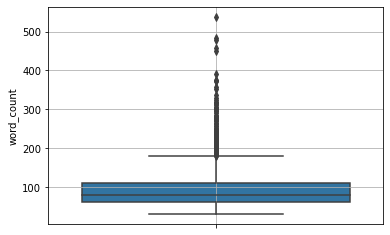

In [267]:
sns.boxplot(data = df_news2, y= 'word_count')
plt.grid(True)
plt.show()

Most of news have 90 - 130 words.

### 5.5 Word of News Wordcloud

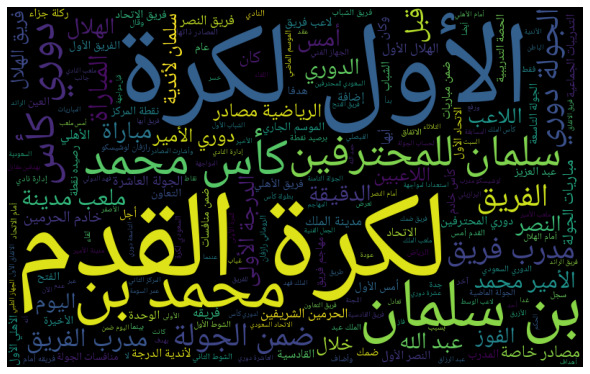

In [258]:
# Define function to reverse word
rtl = lambda w: get_display(reshape(f'{w}'))

# Get unique news into list
words_list = df_news1['news'].unique().tolist()

# Reverse the words of news
words_list = [rtl(word) for word in words_list]
words = ' '.join(words_list)

# NotoNaskhArabic-Regular.ttf is included with notebook
wordcloud = WordCloud(width=800, height=500, stopwords=stop_words, font_path='NotoNaskhArabic-Regular.ttf').generate(words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 5.6 The Distributed of Class

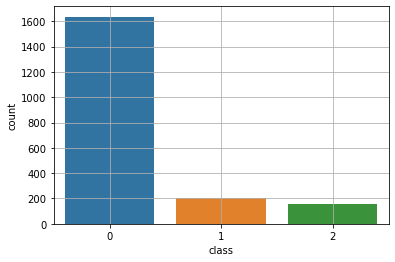

In [266]:
sns.countplot(data = df_news2, x= 'class')
plt.grid(True)
plt.show()

The most of news belong class 0.

### 5.7 Find The City which has The Highest Number of News

In [290]:
df_news2.groupby(by='location')['word_count'].count().sort_values(ascending = False)[:5]

location
الرياض     857
جدة        291
الدمام     199
الأحساء    130
بريدة      129
Name: word_count, dtype: int64

The 'الرياض' has the highest number of news.